### Workflow with Orchestration to produce an enhanced version of a JEP

Implements the following **agentic pattern**:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker

Updates:
* json schema **generated** from pydantic schema
* (18/02/2025) added management of **special instructions**

In [1]:
import re
import json
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated, List
import operator

# to read the pdf
from pdf_reader import PDFReader

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display, Markdown

from oci_models import create_model_for_routing, create_model_for_answer_directly
from jep_structure import STRUCTURE
from utils import get_console_logger

In [2]:
logger = get_console_logger()


#
# Helper functions
#
def extract_file_name(text):
    """
    Extract the file name, enclosed in triple backticks
    """
    match = re.search(r"```(.*?)```", text)
    if match:
        return match.group(1)
    return None


def extract_json_from_text(text):
    """
    Extracts JSON content enclosed within triple backticks, removes 'json' before '{',
    and converts it to a dictionary.

    :param text: The input string containing JSON wrapped in triple backticks.
    :return: A dictionary parsed from the extracted JSON or None if extraction fails.
    """
    # Extract JSON content inside triple backticks
    match = re.search(r"```(.*?)```", text, re.DOTALL)

    if match:
        json_string = match.group(1).strip()  # Extract and strip extra spaces

        # Remove 'json' before the first '{' if present
        json_string = re.sub(r"^\s*json\s*", "", json_string)

        try:
            # Convert extracted JSON string to dictionary
            data_dict = json.loads(json_string)
            return data_dict
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            return None
    else:
        print("No JSON found inside triple backticks.")
        return None

In [3]:
# models used in the rest of the code
llm_reader = create_model_for_answer_directly(temperature=0, max_tokens=1000)
llm_planner = create_model_for_answer_directly(temperature=0, max_tokens=3000)
llm_worker = create_model_for_answer_directly(temperature=0.1, max_tokens=3000)


# Schema for structured output to use in planning
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    special_instructions: str = Field(
        description="Special Instructions to generate the section."
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    request: str
    file_name: str
    file_text: str

    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    worker state
    """

    file_text: str
    section: Section
    completed_sections: Annotated[list, operator.add]


# Augment the LLM with schema for structured output
json_schema = Sections.model_json_schema()

# the LLM used for planning
planner = llm_planner

In [9]:
# Nodes
def file_reader(state: State):
    """
    Extract the file name and read the text
    """
    PROMPT = """
    Analyze the user's request and extract only the file name.
    Provide only the file name enclosed in triple backtick.
    """
    logger.info("Calling file_reader...")

    # prepare the requests to handle input and extract key info (file nam)
    messages = [SystemMessage(content=PROMPT), HumanMessage(content=state["request"])]

    result = llm_reader.invoke(input=messages)

    f_name = extract_file_name(result.content)
    logger.info(f"File to be analyzed is: {f_name}")

    logger.info("Reading file content...")
    pdf_reader = PDFReader(f_name)
    pdf_reader.load_file()
    file_text = pdf_reader.get_text()

    return {"file_name": f_name, "file_text": file_text}


def orchestrator(state: State):
    """Orchestrator: generates a plan for the report"""

    logger.info("Calling planner...")

    _prompt = f"""
    Generate a structured **rewriting plan** for the following text.
    
    ### **Instructions:**
    - Use the predefined sections, descriptions and any special instructions outlined in the given structure: **{STRUCTURE}**.
    - The plan must be structured according to the **JSON schema**: {str(json_schema)}.
    - Only include a section if the provided text contains relevant information to generate it. If no relevant details are found, exclude the section.
    - Ensure that the output **strictly adheres** to the JSON schema.
    - **Do not return the JSON schema itself**—only generate a plan based on the text provided.
    - **Output Format:** Return only the JSON enclosed within triple backticks (` ``` `). **Do not include any explanations, comments, or extra text.**
    
    ### **Text to Rewrite:**
    {state['file_text']}
    """

    logger.info("Planner prompt len is: %d (char)", len(_prompt))
    logger.info("Sections: ")
    logger.info("")

    # Generate queries
    report_sections = planner.invoke(
        [
            HumanMessage(content=_prompt),
        ]
    )

    # transform the string in a dict
    report_sections = extract_json_from_text(report_sections.content)

    return {"sections": report_sections["sections"]}


def worker(state: WorkerState):
    """a Worker, writes a section of the report"""

    # Generate section
    # we're using another model
    # - **Do not include a preamble** or introductory phrase, start directly with the content.
    # to add special instructions
    try:
        # it is optional, to make the code more robust
        special_instructions = state["section"]["special_instructions"]
    except:
        special_instructions = ""

    section = llm_worker.invoke(
        [
            SystemMessage(
                content=f"""
                Write a detailed and well-structured report section based on the given **section name** and **description**.
                
                ### **Instructions:**
                - **Do not copy** from the provided text; instead, rewrite the content clearly and concisely.
                - Use **only** the information available in the provided text. **Do not add external information**.
                - Except for the Table of Contents, after the title of the section, add an introduction describing briefly the content and objectives of the section.
                - Format the response using **Markdown** for better readability.
                - {special_instructions}
                """
            ),
            HumanMessage(
                content=f"""Here is the section name: {state['section']['name']} and description: {state['section']['description']}
                Here is the text: {state['file_text']}"""
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    logger.info("Synthesizer completed !")

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        logger.info(f"Section: {i+1}...")
        logger.info(f"Calling llm for working on section: {s['name']}")
        logger.info(f"Description: {s['description']}")

        # only if there are special instructions
        if len(s["special_instructions"]) > 0:
            logger.info("Special Instructions: %s", s["special_instructions"])

        logger.info("")

    return [
        Send("worker", {"file_text": state["file_text"], "section": s})
        for s in state["sections"]
    ]

In [10]:
# Build workflow with langgraph
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("file_reader", file_reader)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("worker", worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "file_reader")
orchestrator_worker_builder.add_edge("file_reader", "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["worker"]
)
orchestrator_worker_builder.add_edge("worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

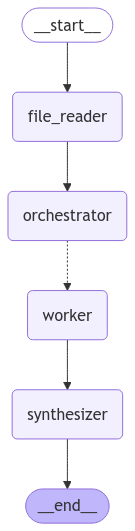

In [11]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [12]:
# Invoke
state = orchestrator_worker.invoke({"request": "please rewrite and improve doc1.pdf"})

2025-02-18 10:51:26,305 - Calling file_reader...
2025-02-18 10:51:27,432 - File to be analyzed is: doc1.pdf
2025-02-18 10:51:27,433 - Reading file content...
2025-02-18 10:51:27,790 - Calling planner...
2025-02-18 10:51:27,790 - Planner prompt len is: 14817 (char)
2025-02-18 10:51:27,790 - Sections: 
2025-02-18 10:51:27,790 - 
2025-02-18 10:51:36,846 - Section: 1...
2025-02-18 10:51:36,847 - Calling llm for working on section: Table of Contents
2025-02-18 10:51:36,849 - Description: This section provides a well-formatted table of contents, where all the other sections are listed.
2025-02-18 10:51:36,850 - Special Instructions: Don't put the number of the pages.
2025-02-18 10:51:36,856 - 
2025-02-18 10:51:36,856 - Section: 2...
2025-02-18 10:51:36,857 - Calling llm for working on section: Overview
2025-02-18 10:51:36,858 - Description: The purpose of this Joint Engagement Plan (JEP) document is to outline Oracle’s approach to addressing Facetrom using Oracle Cloud technology.
2025-02-18

In [13]:
# shows the generated, reviewed document!
Markdown(state["final_report"])

### Table of Contents
This section provides a comprehensive outline of the various components that make up the Proof of Concept Joint Execution Plan. The objective of this section is to offer a clear and concise overview of the different sections that follow, allowing readers to navigate the document with ease and quickly locate specific information. The table of contents serves as a roadmap, highlighting key areas such as the overview, scope and approach, timelines, proof of concept architecture, success criteria, deliverables, and contacts, among others. 

* Overview 
* Scope and Approach 
* Timelines 
* Proof of Concept Architecture 
* Success Criteria 
* Use Case(s) 
* Deliverables 
* Proof of Concept Requirements 
* Contacts

---

### Overview and Description
This section provides an introduction to the Joint Engagement Plan (JEP) document, which outlines Oracle's approach to addressing Facetrom's needs using Oracle Cloud technology. The objective of this section is to give a brief overview of the content and objectives of the JEP document, highlighting the collaboration between Oracle and Facetrom to assess environment requirements, deliver architecture recommendations, and demonstrate the value of Oracle Cloud in achieving Facetrom's business objectives.

The JEP document serves as a guide for both Facetrom and Oracle teams, providing an agreed-upon action plan to maximize the value of their collaboration. The primary focus of this engagement is Facetrom's project to shift its current and growing workload from AWS to Oracle Cloud Infrastructure (OCI), with an emphasis on leveraging OCI's AI and data science capabilities. The project aims to improve efficiencies, enhance scanning quality, and achieve better policy ranking tools. 

Key aspects of the JEP include defining the scope and approach of the Proof of Concept (POC), outlining the timelines for the project, describing the proof of concept architecture, and establishing success criteria. The document also lists the deliverables, proof of concept requirements, and contacts involved in the project. By following this structured approach, Oracle and Facetrom aim to ensure a successful migration and to drive optimum business value through the use of Oracle Cloud technology.

---

### Scope and Approach
This section outlines the scope and approach of the Proof of Concept (POC) project, which aims to migrate Facetrom's workload from Amazon Web Services (AWS) to Oracle Cloud Infrastructure (OCI). The objective of this section is to provide a clear understanding of the project's scope, approach, and key activities involved in achieving the desired outcomes.

The scope of the POC includes the following key activities:
* Creating an OCI account and configuring the OCI tenancy, including setting up networking, security, and storage
* Creating a Kubernetes cluster to support Facetrom's application cloud scanning setup
* Configuring the resource manager to use Terraform deployment for efficient resource management
* Installing customer stack applications to ensure seamless migration
* Configuring Gen AI and Data Science capabilities to improve scanning quality and policy ranking tools

The approach involves a phased implementation, with each phase focusing on specific aspects of the migration, including setting up the OCI environment, configuring networking and security, and deploying Data Science and Gen AI services. The project timeline is estimated to be around 10 weeks, with clear ownership and responsibilities assigned to each phase.

By following this approach, the project aims to achieve the desired outcomes, including improved efficiencies, enhanced scanning quality, and better policy ranking tools, ultimately supporting Facetrom's business objectives.

---

### Timelines
This section provides an overview of the project plan for the Proof of Concept (POC) outlining the major tasks, milestones, and duration. The objective of this section is to provide a clear understanding of the project timeline, which is divided into six phases, spanning a total of 10 weeks.

The project plan is designed to ensure a smooth and efficient execution of the POC, with each phase building on the previous one. The six phases are:

* **Phase 1: Set up an OCI environment** - This phase involves setting up an Oracle Cloud Infrastructure (OCI) environment with all the necessary resources, including implementing tenants for testing. This phase is expected to be completed within 1 week and is owned by Avi Zabary (ACE) and the customer.
* **Phase 2: Configure Networking and Security** - In this phase, the focus is on configuring networking, including load balancers, virtual machines, OKE, object storage, and security features such as policy, limit increase, users, and groups. This phase is expected to be completed within 2 weeks and is owned by Avi Zabary (ACE) and the customer.
* **Phase 3: Configure Monitoring and Logging AI Service** - This phase involves configuring monitoring and logging AI services, which is expected to be completed within 2 weeks. Avi Zabary (ACE) and the customer are responsible for this phase.
* **Phase 4: Configure Data Science and Gen AI** - In this phase, the focus is on configuring data science and Gen AI services, which is expected to be completed within 2 weeks. Avi Zabary (ACE) and the customer are responsible for this phase.
* **Phase 5: Customer Application Installation and Tests** - This phase involves installing the customer's application and conducting tests, which is expected to be completed within 2 weeks. Avi Zabary (ACE) and the customer are responsible for this phase.
* **Phase 6: POC Conclusion and Go Live** - The final phase involves concluding the POC and going live, which is expected to be completed within 1 week. Avi Zabary (ACE), Nir Yaakobi (Sales), and the customer are responsible for this phase.

By following this project plan, the team aims to deliver a production-level working environment that supports the client's product launches using OCI, which could not be achieved with the current vendor. The successful completion of this project is expected to improve the client's scanning quality, policy ranking tool, and overall business value.

---

### Proof of Concept Architecture
The Proof of Concept Architecture section outlines the design and structure of the proposed solution for Facetrom's cloud scanning setup using Oracle Cloud Infrastructure (OCI) and Kubernetes. This section aims to provide a detailed overview of the architecture, its components, and how they will work together to support Facetrom's application and business objectives.

The proposed architecture utilizes OCI's Infrastructure-as-a-Service (IaaS) and Platform-as-a-Service (PaaS) offerings, including Virtual Machines (VMs), Kubernetes, and other services such as Network Load Balancer, Object Storage, and Data Science. The architecture is designed to be scalable, secure, and efficient, with a focus on ease of deployment and performance.

The key components of the architecture include:

* **OCI IaaS (VMs)**: Providing the underlying infrastructure for the application, including compute, storage, and networking resources.
* **Kubernetes**: Managing containerized applications and providing a scalable and secure platform for deployment.
* **Network Load Balancer**: Distributing traffic and ensuring high availability and scalability.
* **Object Storage**: Providing a secure and durable storage solution for data and applications.
* **Data Science**: Enabling advanced analytics and machine learning capabilities to support Facetrom's business objectives.

The architecture is designed to support Facetrom's specific use cases, including:

* **Cloud scanning**: Utilizing OCI's services to scan proposals from other insurance companies and improve scanning quality.
* **Policy ranking tool**: Leveraging Data Science and machine learning capabilities to provide better policy ranking and decision-making.

The success criteria for the Proof of Concept include:

* **Ease of deployment**: Simple and rapid deployment of the architecture.
* **Performance**: Scalable and high-performance architecture that supports Facetrom's business objectives.
* **Data Science**: Effective use of Data Science services to improve scanning quality and policy ranking.

Overall, the Proof of Concept Architecture is designed to provide a robust, scalable, and secure solution for Facetrom's cloud scanning setup, leveraging the strengths of OCI and Kubernetes to support the company's business objectives.

---

### Success Criteria
This section outlines the key objectives and metrics that will be used to measure the success of the Proof of Concept (POC) project. The primary goal of the POC is to assess the feasibility and effectiveness of migrating Facetrom's workload from AWS to Oracle Cloud Infrastructure (OCI). The success criteria are designed to evaluate the ease of deployment, performance, and data science capabilities of the OCI platform.

The success criteria for the POC are as follows:
* **Ease of deployment**: The ability to create a scalable proof of concept in a short timeframe, demonstrating the simplicity and efficiency of the OCI platform.
* **Performance**: The ability to build a multi-region/tenant architecture using OCI services, with the capacity to add more projects to the platform while maintaining optimal performance.
* **Data science capabilities**: The ability to utilize data science services and achieve good results from other insurance companies by at least 10%, including support for the Hebrew language.

By achieving these success criteria, the POC aims to demonstrate the value and benefits of migrating to the OCI platform, and to provide a solid foundation for future deployments and expansions. The success of the POC will be measured against these criteria, and the results will be used to inform future decisions and improvements.

---

### Deliverables
#### Introduction
This section outlines the expected outcomes of the Proof of Concept (POC) joint execution plan between Oracle and Facetrom. The primary objective is to deliver a production-level working environment that supports product launches using Oracle Cloud Infrastructure (OCI), which Facetrom cannot currently achieve with their existing vendor. This section provides an overview of the deliverables, focusing on the key outcomes and benefits of the POC.

#### Production-Level Working Environment
The primary deliverable of the POC is a production-level working environment that enables Facetrom to launch products using OCI. This environment will be designed to support Facetrom's business objectives, including improving scanning quality and policy ranking tools. The production-level environment will be scalable, efficient, and capable of handling increased workloads.

#### Key Features and Benefits
The deliverables will include:
* A fully configured OCI account with necessary resources, including networking, security, and storage
* A Kubernetes cluster to support Facetrom's application cloud scanning setup
* Integration with Gen AI and Data Science services to enhance scanning quality and policy ranking tools
* A scalable and efficient architecture that can handle increased workloads and support future product launches
* Improved performance and ease of deployment, enabling Facetrom to quickly set up servers, including DB and load balancers, for peak times using OCI services

#### Success Criteria
The success of the deliverables will be measured against the following criteria:
* Ease of deployment: simple and short timespan to create a scalable proof of concept
* Performance: building the application in a multi-region/tenant architecture using OCI services as needed, while adding more projects to the platform
* Data Science service: receiving good results from other insurance companies by 10%, including Hebrew support

By achieving these deliverables, Facetrom will be able to migrate their workload from AWS to OCI, improving efficiencies and driving business value. The production-level working environment will enable Facetrom to launch products and support their business growth, while Oracle will provide the necessary support and expertise to ensure a successful migration.

---

### Proof of Concept Requirements and IAAS + PaaS
#### Introduction
This section outlines the requirements for the Proof of Concept (POC) project, focusing on Infrastructure as a Service (IAAS) and Platform as a Service (PaaS) components. The objective is to provide a clear understanding of the necessary elements for a successful POC, ensuring a smooth transition of Facetrom's workload from Amazon Web Services (AWS) to Oracle Cloud Infrastructure (OCI).

#### Overview of IAAS + PaaS Requirements
The POC requires the setup of an OCI environment with IAAS and PaaS components, including:
* Virtual Machines (VMs)
* Kubernetes
* Networking (including Load Balancer)
* Object Storage
* Monitoring and logging
* Data Science and integration with third-party software
* Generative AI

These components will enable Facetrom to deploy their application and test the scalability, performance, and ease of deployment of the OCI environment.

#### Key Requirements
The following are the key requirements for the POC:
* Create an OCI account and configure the tenancy (including Networking, Security, and Storage)
* Set up a Kubernetes cluster and configure the resource manager to use Terraform deployment
* Install customer stack applications and configure Gen AI and Data Science
* Define Oracle and third-party Cloud Services to be utilized during the POC
* Configure the POC environment and run use cases against the test plan

#### Success Criteria
The success of the POC will be measured by the following criteria:
* Ease of deployment: simple and short timespan to create a scalable POC
* Performance: building the application in a multi-region/tenant architecture using OCI services
* Data Science service: receiving good results from other insurance companies by 10% (including Hebrew)

#### Deliverables
The POC is expected to deliver a production-level working environment that supports product launches, which the client wanted to do using OCI but could not do today with the current vendor. The deliverables include:
* A fully functional OCI environment with IAAS and PaaS components
* A tested and validated application deployment
* A report on the POC results, including performance, scalability, and ease of deployment.

---

### Contacts
This section provides an overview of the key contacts involved in the Proof of Concept (POC) Joint Execution Plan between Oracle and Facetrom. The objective of this section is to list the contacts, their roles, and email addresses for easy reference and communication.

The following table summarizes the contacts' information:

| **Name** | **Role** | **Email** |
| --- | --- | --- |
| Nir Yaakobi | Cloud Sales rep | nir.yaakobi@oracle.com |
| Ronen Zagron | CTO | ronen@facetrom.com |
| Yaron Rotshtein | Cloud Sales Leader | yaron.rotshtein@oracle.com |
| Avi Zabary (ACE) |  | avi.zabary@oracle.com |
| Asaf Rabinowicz | Science Specialist | assaf.rabinowicz@oracle.com |

These contacts are categorized into four groups:
* **POC - Joint Execution Plan Author**: Nir Yaakobi
* **POC Sponsors – Customer and Oracle**: Ronen Zagron, Nir Yaakobi, and Yaron Rotshtein
* **POC Team Members – Customer**: Ronen Zagron
* **POC Team Members - Oracle**: Avi Zabary (ACE) and Asaf Rabinowicz